In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

# from bin import utils

In [2]:
# read in bins
adata = {}
for sample in ['B922-1', 'B922-2', 'B924-1', 'B924-2', 'B926-1', 'B926-2']:
    adata[sample] = sc.read_h5ad('/home/wpy/stereoseq/20240502-SPACseq/h5_files/' + sample + '.bin200.h5')
    adata[sample].obs['marker'] = sample
adata_combined = ad.concat(adata.values(), join='outer')
adata_combined.obs_names_make_unique()

fdata = adata_combined[:, ~adata_combined.var_names.str.startswith('sg')].copy()
gdata = adata_combined[:, adata_combined.var_names.str.startswith('sg')].copy()

gdata.X[:, gdata.var_names == 'sgNTC'] = gdata[:, 'sgNTC'].X.toarray() + gdata[:, 'sgnon-targeting_1_gene'].X.toarray() + gdata[:, 'sgnon-targeting_2_gene'].X.toarray()
gdata = gdata[:, ~gdata.var_names.str.startswith('sgnon-targeting')].copy()

fdata = utils.remove_mito_ribo_hk_lnc_genes(fdata)
fdata.layers['counts'] = fdata.X.copy()

sc.pp.normalize_total(fdata, inplace=True)
# sc.pp.log1p(fdata)

del adata
del adata_combined

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


NameError: name 'utils' is not defined

In [3]:
sc.pp.highly_variable_genes(fdata, n_top_genes=10000, flavor='cell_ranger', inplace=True)
hvg_data = fdata[:, fdata.var['highly_variable']].copy()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [24]:
from sklearn.decomposition import NMF
cnt_matrix = hvg_data.X.toarray()
model = NMF(n_components=100, verbose=1, max_iter=2000)
cnt_matrix_trans = model.fit_transform(cnt_matrix)

import pickle
pickle.dump(model, open('./nmf_model.hvg.100.pkl', 'wb'))

violation: 1.0
violation: 0.12266181877565031
violation: 0.1176630747068307
violation: 0.14311703023966285
violation: 0.15599542484878443
violation: 0.1499384922159289
violation: 0.13393313988527744
violation: 0.12416416832788171
violation: 0.1173978001233975
violation: 0.11058094611213447
violation: 0.10467037420813767
violation: 0.09893494433638199
violation: 0.0922940675962901
violation: 0.0855732754161862
violation: 0.07945843590527396
violation: 0.07427205060687023
violation: 0.0697993240195978
violation: 0.06484910414665948
violation: 0.06029589009756161
violation: 0.057166126949871096
violation: 0.05498888087900118
violation: 0.053215200264404926
violation: 0.05147900496351696
violation: 0.04980866999551159
violation: 0.04789840126337178
violation: 0.045958979298284214
violation: 0.04439575302513581
violation: 0.042949700981785494
violation: 0.0411421940343497
violation: 0.039694039629988596
violation: 0.03866925681514828
violation: 0.03758635987381324
violation: 0.0368036443391

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


In [25]:
np.save('./nmf_matrix.hvg.100.npy', cnt_matrix_trans)

In [6]:
cnt_matrix_trans = np.load('/home/wpy/stereoseq/20240502-SPACseq/nmf_matrix.200.npy')

In [6]:
cnt_matrix_trans

array([[0.20772044, 0.04469369, 0.22494924, ..., 0.12379111, 0.        ,
        0.02204491],
       [0.404171  , 0.09686304, 0.30855936, ..., 0.16693428, 0.        ,
        0.        ],
       [0.01565519, 0.06568775, 0.        , ..., 0.4130335 , 0.12329327,
        0.44969267],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [7]:
from scipy.stats import pearsonr
from tqdm import tqdm

corr_matrix = np.zeros((cnt_matrix_trans.shape[1], cnt_matrix_trans.shape[1]))
for i in tqdm(range(cnt_matrix_trans.shape[1])):
    for j in range(i, cnt_matrix_trans.shape[1]):
        corr_matrix[i, j] = pearsonr(cnt_matrix_trans[:, i], cnt_matrix_trans[:, j])[0]

  0%|          | 0/200 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [28]:
for i in tqdm(range(corr_matrix.shape[1])):
    for j in range(i):
        corr_matrix[i, j] = corr_matrix[j, i]

np.save('./nmf_corr_matrix.hvg.100.npy', corr_matrix)

100%|██████████| 100/100 [00:00<00:00, 21877.24it/s]


In [7]:
corr_matrix = np.load('/home/wpy/stereoseq/20240502-SPACseq/nmf_corr_matrix.200.npy')

In [14]:
import consensusclustering as cc
from sklearn.cluster import AgglomerativeClustering

cc_model = cc.ConsensusClustering(
    AgglomerativeClustering(),
    min_clusters=4,
    max_clusters=20,
    n_resamples=100,
    resample_frac=0.8,
    k_param='n_clusters'
)
cc_model.fit(corr_matrix)
cc_model.best_k()

7

In [52]:

heatmap = model.plot_clustermap(k=7)
reordered_idx = heatmap.dendrogram_row.reordered_ind
plt.close()

row_colors = ['silver'] * 18 + ['gold'] * 13 + ['tomato'] * 15 + ['cornflowerblue'] * 9 + ['palegreen'] * 4 + ['gold'] * 8 + ['silver'] * 200
# heatmap = cc_model.plot_clustermap(k=9, cmap='YlGnBu', vmin=0, vmax=1, dendrogram_ratio=1e-9, cbar_pos=None, row_cluster=True, col_cluster=True)
heatmap = sns.clustermap(cc_model.consensus_k(7)[reordered_idx, :][:, reordered_idx][133:, 133:], cmap='YlGnBu', vmin=0, vmax=1,
                         dendrogram_ratio=1e-9, cbar_pos=None, row_cluster=False, col_cluster=False, row_colors=row_colors,
                         figsize=(4, 4))

# heatmap.ax_heatmap.set_yticks(np.arange(0, 36, 1) + 1/2, np.arange(0, 36, 1), fontsize=6, rotation=0)
heatmap.ax_heatmap.set_yticks([])
heatmap.ax_heatmap.set_xticks([])
plt.show()

AttributeError: 'NMF' object has no attribute 'plot_clustermap'

In [3]:
fdata = sc.read_h5ad('/home/wpy/stereoseq/20240502-SPACseq/h5_files/Multitime.tissue.bin200.h5')

In [4]:
# cluster enrichment
import pickle

n_top = 50
model = pickle.load(open('/home/wpy/stereoseq/20240502-SPACseq/nmf_model.hvg.100.pkl', 'rb'))

fdata_bin100 = sc.read_h5ad('/home/wpy/stereoseq/20240502-SPACseq/RNA/Multitime.clustered.h5')
genes = fdata.var_names[np.argsort(model.components_, axis=1)[:, -n_top:].flatten()]
genes = [x for x in genes if x in fdata_bin100.var_names]

gene_df = pd.DataFrame(fdata_bin100[:, genes].X.toarray(), index=fdata_bin100.obs_names, columns=fdata_bin100[:, genes].var_names)
gene_df = pd.concat([gene_df, fdata_bin100.obs.cluster_cellcharter_givenk], axis=1)
gene_df['x'] = fdata_bin100.obsm['spatial'][:, 0] // 200 * 200
gene_df['y'] = fdata_bin100.obsm['spatial'][:, 1] // 200 * 200
gene_df['marker'] = fdata_bin100.obs.marker.tolist()

In [8]:
programs = [list(range(133, 133 + 18)), list(range(133 + 18, 133 + 31)), list(range(133 + 31, 133 + 46)), list(range(133 + 46, 133 + 55)), list(range(133 + 59, 133 + 63)), list(range(133 + 63, 133 + 67))]
combined_matrix_trans = np.zeros((len(programs), len(fdata.obs_names)))
for i, program in enumerate(programs):
    combined_matrix_trans[i, :] = cnt_matrix_trans[:, program].sum(axis=1)
    combined_matrix_trans[i, :] = combined_matrix_trans[i, :] / combined_matrix_trans[i, :].sum() * 1e3 

In [9]:
# pd.DataFrame(combined_matrix_trans).to_csv('./nmf_program_matrix.csv', index=False)

import pickle
model = pickle.load(open('/home/wpy/stereoseq/20240502-SPACseq/nmf_model.200.pkl', 'rb'))
# pd.DataFrame(model.components_).to_csv('./nmf_program_components.csv', index=False)

/tmp/ipykernel_175671/4271159128.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['c' + str(x) for x in range(12)])


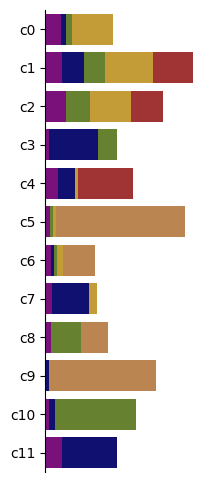

In [43]:
c_df = pd.DataFrame({
    'cluster': combined_matrix_trans.argmax(axis=0)
}, index=fdata.obs_names).sort_values('cluster')

env_df = pd.concat([pd.DataFrame(fdata.obsm['spatial'] // 200 * 200, index=fdata.obs_names, columns=['x', 'y']),
    c_df.cluster,
    pd.DataFrame(fdata.obs.marker.map({
    'B926-1': '2-1',
    'B926-2': '2-2',
    'B924-1': '1-1',
    'B924-2': '1-2',
    'B922-1': '3-1',
    'B922-2': '3-2'
}))], axis=1).set_index(['x', 'y', 'marker'])
niche_df = gene_df[['x', 'y', 'marker', 'cluster_cellcharter_givenk']].set_index(['x', 'y', 'marker'])
p_df = env_df.join(niche_df).groupby('cluster').value_counts().reset_index()

p_df.loc[p_df.cluster == 4, 'count'] = np.array(p_df.loc[p_df.cluster == 5, 'count']) + np.array(p_df.loc[p_df.cluster == 4, 'count'])
p_df.loc[p_df.cluster == 3, 'count'] = np.array(p_df.loc[p_df.cluster == 4, 'count']) + np.array(p_df.loc[p_df.cluster == 3, 'count'])
p_df.loc[p_df.cluster == 2, 'count'] = np.array(p_df.loc[p_df.cluster == 3, 'count']) + np.array(p_df.loc[p_df.cluster == 2, 'count'])
p_df.loc[p_df.cluster == 1, 'count'] = np.array(p_df.loc[p_df.cluster == 2, 'count']) + np.array(p_df.loc[p_df.cluster == 1, 'count'])
p_df.loc[p_df.cluster == 0, 'count'] = np.array(p_df.loc[p_df.cluster == 1, 'count']) + np.array(p_df.loc[p_df.cluster == 0, 'count'])

plt.figure(figsize=(2, 6))
colors = ['firebrick', 'peru', 'goldenrod', 'olivedrab', 'navy', 'darkmagenta']
for i, cluster in enumerate(p_df.cluster.unique()):
    ax = sns.barplot(p_df.loc[p_df.cluster == cluster], y='cluster_cellcharter_givenk', x='count', color=colors[i], orient='h')
sns.despine()
# ax.set_ylabel('Spatial Niche')
ax.set_ylabel('')
ax.spines['bottom'].set_visible(False)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticklabels(['c' + str(x) for x in range(12)])

# plt.rcParams['pdf.fonttype']=42
# plt.savefig("./plots/cluster_environment_proportion.pdf", format="pdf", bbox_inches='tight')

plt.show()

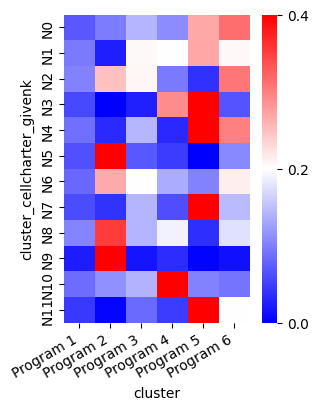

In [14]:
c_df = pd.DataFrame({
    'cluster': combined_matrix_trans.argmax(axis=0)
}, index=fdata.obs_names).sort_values('cluster')

env_df = pd.concat([pd.DataFrame(fdata.obsm['spatial'] // 200 * 200, index=fdata.obs_names, columns=['x', 'y']),
    c_df.cluster,
    pd.DataFrame(fdata.obs.marker.map({
    'B926-1': '2-1',
    'B926-2': '2-2',
    'B924-1': '1-1',
    'B924-2': '1-2',
    'B922-1': '3-1',
    'B922-2': '3-2'
}))], axis=1).set_index(['x', 'y', 'marker'])
niche_df = gene_df[['x', 'y', 'marker', 'cluster_cellcharter_givenk']].set_index(['x', 'y', 'marker'])
p_df = env_df.join(niche_df).groupby('cluster').value_counts().unstack()
p_df = p_df.div(p_df.sum(axis=0), axis=1)

plt.figure(figsize=(3, 4))
sns.heatmap(p_df.T, cmap='bwr', vmin=0, vmax=0.4, cbar_kws={'ticks': [0, 0.2, 0.4]})
plt.yticks(np.array(range(12)) + 0.5, ['N' + str(x) for x in range(12)])
plt.xticks(np.array(range(6)) + 0.5, ['Program ' + str(x) for x in range(1, 7)], rotation=30, ha='right')
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('/home/wpy/stereoseq/20240502-SPACseq/plots/cluster_environment_proportion_heatmap.pdf', format='pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_39913/2183035836.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df, x='cluster_cellcharter_givenk', y='value', hue='Time', palette=custom_colors, dodge=True, ci=None)
/tmp/ipykernel_39913/2183035836.py:18: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.barplot(data=plot_df, x='cluster_cellcharter_givenk', y='value', hue='Time', palette=custom_colors, dodge=True, ci=None)


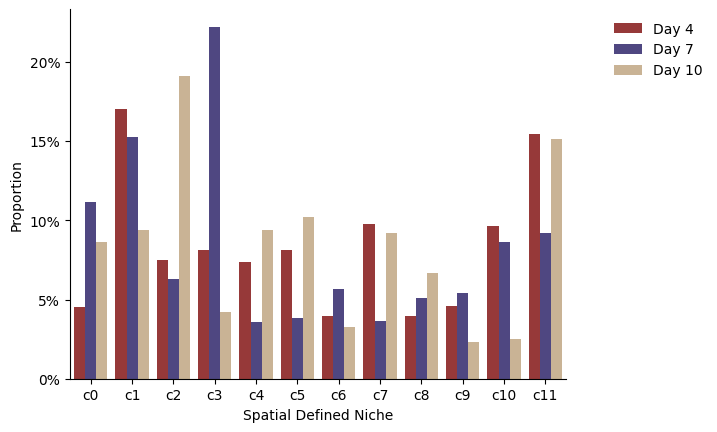

In [61]:
plot_df = fdata_bin100.obs[['cluster_cellcharter_givenk', 'marker']].value_counts().unstack()
plot_df = plot_df.div(plot_df.sum(axis=0), axis=1)
plot_df = plot_df.melt(ignore_index=False)
plot_df['Time'] = plot_df.marker.map(lambda x: x.split('-')[0]).map(lambda x: 'Day 4' if x == '1' else ('Day 7' if x == '2' else 'Day 10'))
custom_colors = ['brown', # EMT
                 'darkslateblue', # Tumor APC
                 'tan', # Fibro
                 'lightpink', # APC
                 'indigo', # Fibro Tumor
                 'wheat', # Fibro
                 'indianred', # Necrosis
                 'beige', # Fibro
                 'sandybrown', # Fibro
                 'peru', # Fibro Tumor
                 'orchid', # APC
                 'mediumvioletred', # Tumor
]
sns.barplot(data=plot_df, x='cluster_cellcharter_givenk', y='value', hue='Time', palette=custom_colors, dodge=True, ci=None)
sns.despine()
plt.ylabel('Proportion')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.3, 1), frameon=False)

plt.xticks(list(range(12)), ['c' + str(x) for x in range(12)])
plt.xlabel('Spatial Defined Niche')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig("./plots/cluster_proportion_crosstime.pdf", format="pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_49957/842979567.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df, x='cluster', y='value', hue='Time', palette=custom_colors, dodge=True, ci=None)
/tmp/ipykernel_49957/842979567.py:21: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.barplot(data=plot_df, x='cluster', y='value', hue='Time', palette=custom_colors, dodge=True, ci=None)


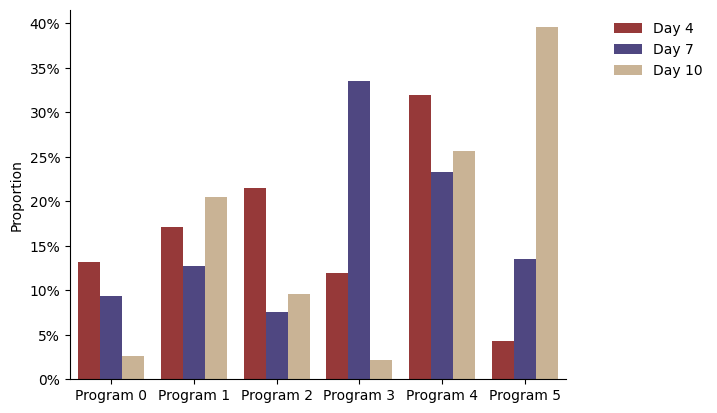

In [16]:
# color_map = ['firebrick', 'peru', 'goldenrod', 'olivedrab', 'navy', 'darkmagenta']
custom_colors = ['brown', # EMT
                 'darkslateblue', # Tumor APC
                 'tan', # Fibro
                 'lightpink', # APC
                 'indigo', # Fibro Tumor
                 'wheat', # Fibro
                 'indianred', # Necrosis
                 'beige', # Fibro
                 'sandybrown', # Fibro
                 'peru', # Fibro Tumor
                 'orchid', # APC
                 'mediumvioletred', # Tumor
]
plot_df = env_df.reset_index().groupby(['marker'])['cluster'].value_counts().unstack()
plot_df = plot_df.div(plot_df.sum(axis=1), axis=0)

plot_df = plot_df.melt()
plot_df['Time'] = ['Day 4', 'Day 4', 'Day 7', 'Day 7', 'Day 10', 'Day 10'] * 6

sns.barplot(data=plot_df, x='cluster', y='value', hue='Time', palette=custom_colors, dodge=True, ci=None)

sns.despine()
plt.xlabel('')
plt.ylabel('Proportion')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.legend(title='', loc='upper right', bbox_to_anchor=(1.3, 1), frameon=False,
           labels=['Day 4', 'Day 7', 'Day 10'])
plt.xticks(list(range(6)), ['Program ' + str(x) for x in range(6)])

plt.rcParams['pdf.fonttype'] = 42
plt.savefig("./plots/nmf_program_proportion_crosstime.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
bulk_df = df.groupby(['cluster_cellcharter_givenk', 'marker']).sum().T

In [189]:
n_top = 20
gene_idx = np.argsort(model.components_, axis=1)[:, -n_top:].flatten()
df = pd.DataFrame(columns=['Gene', 'Cluster'])
for idx, i in enumerate([[0, 18], [18, 31], [31, 46], [46, 55], [59, 63], [63, 67]]):
    df = pd.concat([df, pd.DataFrame({
        'Gene': np.unique(hvg_data.var_names[gene_idx[i[0]*n_top:(i[1]+1)*n_top]]),
        'Cluster': idx
    })])
df.to_csv('./DEG.csv', index=False, sep='\t')

In [190]:
!sshpass -p wang2024 ssh wpy@172.16.10.103 "mamba run -n gsea python ~/stereoseq/20240502-SPACseq/enrich.py"

Gene       object
Cluster     int64
dtype: object
/home/wpy/stereoseq/20240502-SPACseq/bin/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
Enrichment analysis for list 0 completed successfully: 3301
Enrichment analysis for list 1 completed successfully: 2985
Enrichment analysis for list 2 completed successfully: 2905
Enrichment analysis for list 3 completed successfully: 2646
Enrichment analysis for list 4 completed successfully: 1402
Enrichment analysis for list 5 completed successfully: 1498



In [220]:
for i in range(6):
    enr = pd.read_csv(f"./GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False)
    results = results[results["Adjusted P-value"] < 0.05]
    results = results.loc[:, ["Term", "Genes", "Adjusted P-value"]]
    results["Cluster"] = i
    results["Gene Counts"] = results["Genes"].str.split(";").apply(len)
    results["Term"] = results["Term"].str.split("R-HSA").str[0]
    results["Term"] = results["Term"].str.split("\(").str[0]
    results = results.groupby("Cluster", as_index=False).apply(lambda x: x.sort_values(by='Adjusted P-value', ascending=True)).reset_index(drop=True)
    if not i: go_df = results
    else: go_df = pd.concat([go_df, results], axis=0)
# go_df.to_csv('./GO/Reactome.csv', index=None, sep='\t')
go_df

<>:9: SyntaxWarning: invalid escape sequence '\('
<>:9: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_72899/1626236204.py:9: SyntaxWarning: invalid escape sequence '\('
  results["Term"] = results["Term"].str.split("\(").str[0]
/tmp/ipykernel_72899/1626236204.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = results.groupby("Cluster", as_index=False).apply(lambda x: x.sort_values(by='Adjusted P-value', ascending=True)).reset_index(drop=True)
/tmp/ipykernel_72899/1626236204.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operati

,Term,Genes,Adjusted P-value,Cluster,Gene Counts
0,Immune System,IFITM3;ARPC1B;HEXB;RAB3D;CTSZ;SNAP23;RNF19B;CL...,1.051248e-08,0,69
1,Actin Filament Organization,MARCKSL1;GSN;TPM2;TPM1;EMP2;MYO7A;CORO1A;AIF1;...,1.371298e-06,0,16
2,Lysosome,SCARB2;CD63;ASAH1;HEXB;CTSZ;HEXA;LAPTM5;GNPTAB...,1.390442e-06,0,14
3,Innate Immune System,C1QB;CD63;ASAH1;ARPC1B;HEXB;RAB3D;CTSZ;SNAP23;...,2.502772e-06,0,42
4,Neutrophil Degranulation,CD63;ASAH1;HEXB;RAB3D;CTSZ;SNAP23;MGST1;PRCP;C...,3.987579e-06,0,26
...,...,...,...,...,...
48,Toll-like receptor signaling pathway,IFNAR2;CXCL9;SPP1;MAPK3,3.715484e-02,5,4
49,HIF-1 signaling pathway,TRF;ALDOA;HIF1A;MAPK3,3.819073e-02,5,4
50,Regulation Of Stress-Activated MAPK Cascade,TAOK3;GSTP1;MAPK3,4.224601e-02,5,3
51,Cardiac Cell Development,TCAP;TTN,4.325796e-02,5,2


In [313]:
go_df[go_df.Cluster == 5].head(30)


,Term,Genes,Adjusted P-value,Cluster,Gene Counts
0,Striated Muscle Contraction,DES;TPM2;TNNC2;TPM1;TNNT3;TNNI2;TCAP;VIM,1.214811e-09,5,8
1,Striated Muscle Contraction,CSRP3;GRK2;TNNC2;TPM1;TNNT3;TNNI2;TCAP;TTN,2.827899e-07,5,8
2,Sarcomere Organization,CSRP3;TPM1;TNNT3;ANKRD1;TCAP;TTN,2.202336e-06,5,6
3,Muscle Contraction,MYH2;DES;TPM2;TPM1;ANKRD2;ALDOA;CRYAB;TTN,5.484339e-06,5,8
4,Actin Filament Organization,MARCKS;TPM2;TPM1;XIRP2;TCAP;TAGLN2;EMP2;ALDOA;TTN,7.693891e-06,5,9
5,Myofibril Assembly,CSRP3;TPM1;TNNT3;ANKRD1;TCAP;TTN,1.625628e-05,5,6
6,Cardiac Muscle Contraction,CSRP3;GRK2;TPM1;TCAP;TTN,7.833126e-05,5,5
7,Heart Contraction,CSRP3;GRK2;TPM1;TCAP;TTN,1.995863e-04,5,5
8,Skeletal Muscle Contraction,TNNC2;TNNT3;TCAP;TNNI2,1.995863e-04,5,4
9,Actomyosin Structure Organization,CSRP3;TPM1;TNNT3;ANKRD1;TCAP;TTN,1.995863e-04,5,6


/tmp/ipykernel_72899/2803712138.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_72899/2803712138.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_72899/2803712138.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_72899/2803712138.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipykern

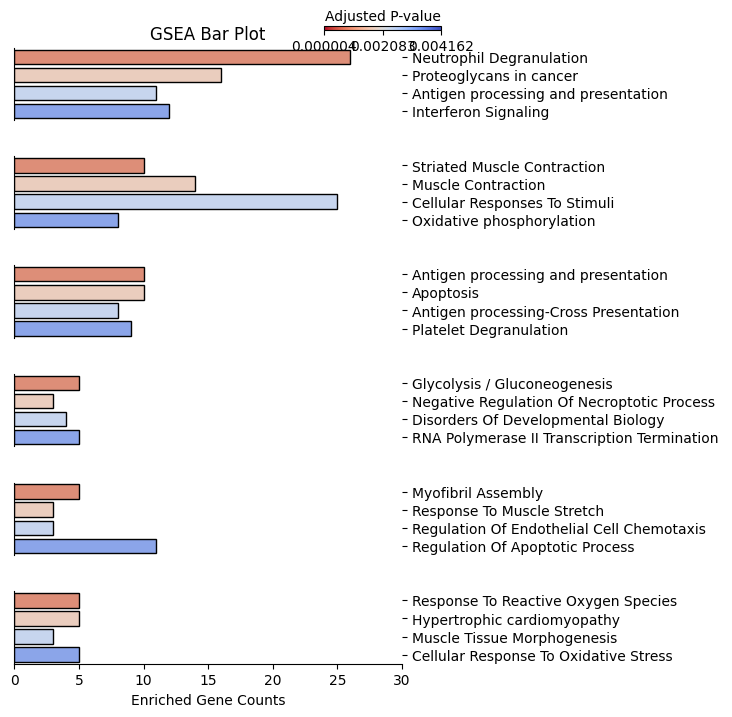

In [317]:
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(6, 1, figsize=(5, 8))
for cluster in range(6):
    if cluster == 0:
        gsea_results = go_df[go_df["Cluster"] == cluster].iloc[[4, 7, 6, 34], :]
    elif cluster == 1:
        gsea_results = go_df[go_df["Cluster"] == cluster].iloc[[0, 2, 7, 14], :]
    elif cluster == 2:
        gsea_results = go_df[go_df["Cluster"] == cluster].iloc[[3, 12, 29, 25], :]
    elif cluster == 3:
        gsea_results = go_df[go_df["Cluster"] == cluster].iloc[[10, 15, 0, 8], :]
    elif cluster == 4:
        gsea_results = go_df[go_df["Cluster"] == cluster].iloc[[2, 4, 5, 25], :]
    else:
        gsea_results = go_df[go_df["Cluster"] == cluster].iloc[[15, 23, 19, 29], :]

    barplot = sns.barplot(
        x='Gene Counts', 
        y='Term', 
        data=gsea_results, 
        palette="coolwarm_r",
        edgecolor='black',
        ax=ax[cluster]
    )
    # for tick in ax[cluster].get_xticks():
        # ax[cluster].axvline(x=tick, linestyle='--', color='gray', alpha=0.5)

    norm = plt.Normalize(gsea_results['Adjusted P-value'].min(), gsea_results['Adjusted P-value'].max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm)
    sm.set_array([])
    if cluster == 0:
        cax = inset_axes(ax[cluster], width="30%", height="5%", loc='upper right',
                         bbox_to_anchor=(0.1, 0.3, 1, 1), bbox_transform=ax[cluster].transAxes, borderpad=0)

        cbar = fig.colorbar(sm, cax=cax, label="Adjusted P-value", orientation='horizontal', shrink=0.1)
        cbar.ax.xaxis.set_label_position('top')
    # else: cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', shrink=0.1)

        cbar_ticks = np.linspace(gsea_results['Adjusted P-value'].min(), gsea_results['Adjusted P-value'].max(), num=3)  # Adjust num for density
        cbar.set_ticks(cbar_ticks)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # ax[cluster].set_xscale('log')
    ax[cluster].yaxis.tick_right()
    ax[cluster].set_ylabel('')

    ax[cluster].set_xlabel('')
    # ax[cluster].set_ylabel(f'Cluster {cluster}')
    ax[cluster].set_xlim(0, 30)

    if cluster != 5:
        ax[cluster].set_xticks([])
        sns.despine(ax=ax[cluster], left=False, bottom=True)
    else:
        sns.despine(ax=ax[cluster], left=False, bottom=False)


plt.subplots_adjust(hspace=0.5)
ax[0].set_title('GSEA Bar Plot')
ax[5].set_xlabel('Enriched Gene Counts')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/nmf_program_gsea.pdf', dpi=300, format='pdf')
plt.show()

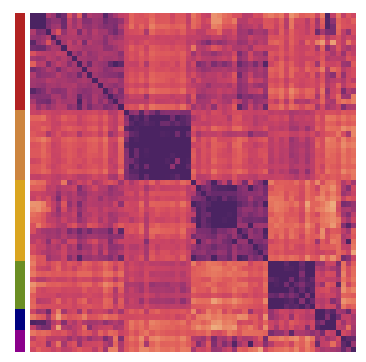

In [159]:
row_colors = ['firebrick'] * 18 + ['peru'] * 13 + ['goldenrod'] * 15 + ['olivedrab'] * 9 + ['navy'] * 4 + ['darkmagenta'] * 100
heatmap = sns.clustermap(np.array(pd.DataFrame(corr_matrix[reordered_idx, :][:, reordered_idx]).iloc[np.r_[133:188, 192:200], np.r_[133:188, 192:200]]), cmap='flare', vmin=-0.4, vmax=0.4, figsize=(4, 4),
               dendrogram_ratio=1e-9, cbar_pos=None, row_cluster=False, col_cluster=False, row_colors=row_colors)
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])
plt.show()

In [53]:
# reordered_idx = [list(range(133, 133 + 18)), list(range(133 + 18, 133 + 31)), list(range(133 + 31, 133 + 46)), list(range(133 + 46, 133 + 55)), list(range(133 + 59, 133 + 63)), list(range(133 + 63, 133 + 67))]
reordered_nmf = cnt_matrix_trans[:, reordered_idx]

sample_idx = np.where(fdata.obs['marker'].values == 'B926-1')[0]

plt.figure(figsize=(5, 5))
sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=[x if x < 0.5 else 0.5 for x in reordered_nmf[sample_idx, 196:200].mean(axis=1)],
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2,
            )
plt.gca().invert_yaxis()
plt.gca().set_facecolor('black')
plt.xticks([])
plt.yticks([])
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [164]:
reordered_nmf

array([[0.02204491, 0.00951072, 0.00051802, ..., 0.        , 0.        ,
        0.04545782],
       [0.        , 0.00814774, 0.00059828, ..., 0.        , 0.        ,
        0.02039211],
       [0.44969267, 0.0093084 , 0.00094869, ..., 0.09899671, 0.        ,
        0.03805642],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

NameError: name 'reordered_idx' is not defined

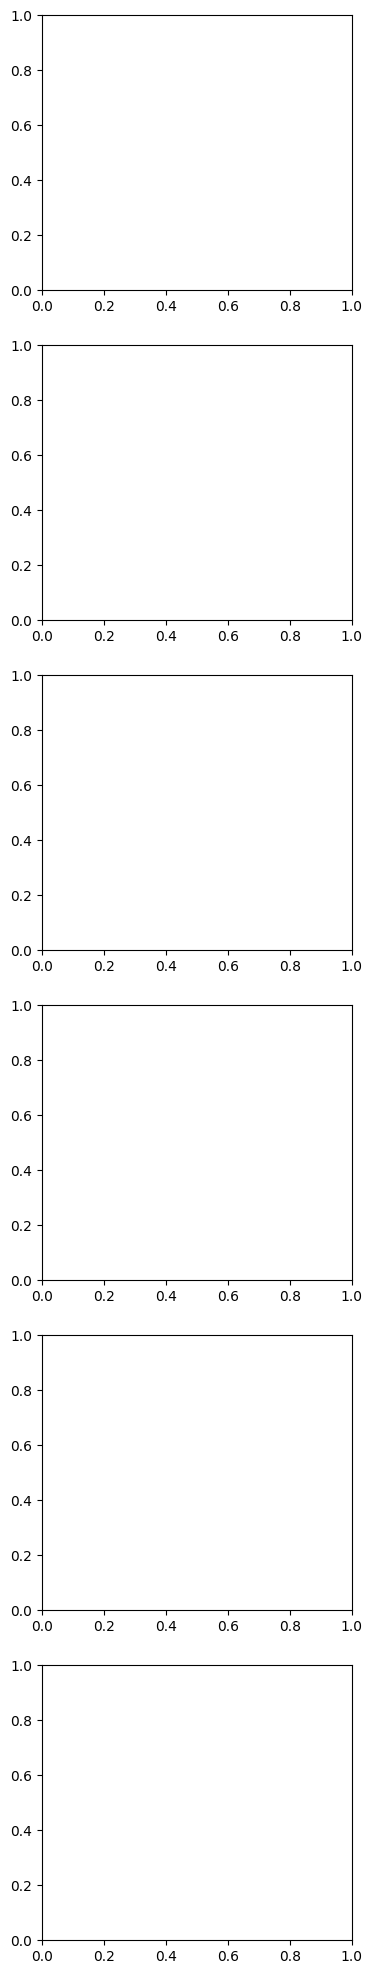

In [49]:
_, ax = plt.subplots(6, 1, figsize=(4, 25))
reordered_nmf = cnt_matrix_trans[:, reordered_idx]

sample = 'B922-1'
sample_idx = np.where(fdata.obs['marker'].values == f'{sample}')[0]

sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 133:151].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2, ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_facecolor('black')
ax[0].set_xticks([])
ax[0].set_yticks([])

sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 151:164].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2, ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_facecolor('black')
ax[1].set_xticks([])
ax[1].set_yticks([])

sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 164:179].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2, ax=ax[2])
ax[2].invert_yaxis()
ax[2].set_facecolor('black')
ax[2].set_xticks([])
ax[2].set_yticks([])

sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 179:188].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2, ax=ax[3])
ax[3].invert_yaxis()
ax[3].set_facecolor('black')
ax[3].set_xticks([])
ax[3].set_yticks([])

sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 192:196].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2, ax=ax[4])
ax[4].invert_yaxis()
ax[4].set_facecolor('black')
ax[4].set_xticks([])
ax[4].set_yticks([])

sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 196:200].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2, ax=ax[5])
ax[5].invert_yaxis()
ax[5].set_facecolor('black')
ax[5].set_xticks([])
ax[5].set_yticks([])

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig(f'./plots/nmf_kde_{sample}.pdf', dpi=300)
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(


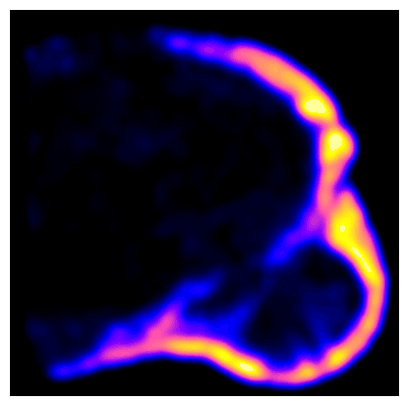

In [81]:
reordered_nmf = cnt_matrix_trans[:, reordered_idx]

sample_idx = np.where(fdata.obs['marker'].values == 'B926-1')[0]

plt.figure(figsize=(5, 5))
sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 47:55].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('black')
plt.xticks([])
plt.yticks([])
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(


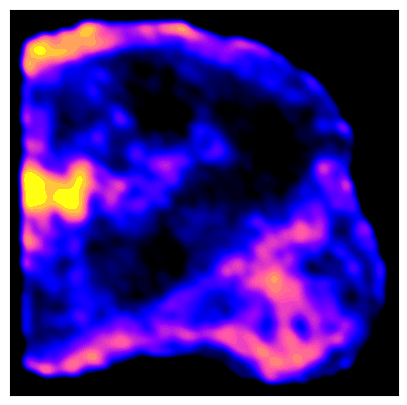

In [82]:
reordered_nmf = cnt_matrix_trans[:, reordered_idx]

sample_idx = np.where(fdata.obs['marker'].values == 'B926-1')[0]

plt.figure(figsize=(5, 5))
sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 81:89].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('black')
plt.xticks([])
plt.yticks([])
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(


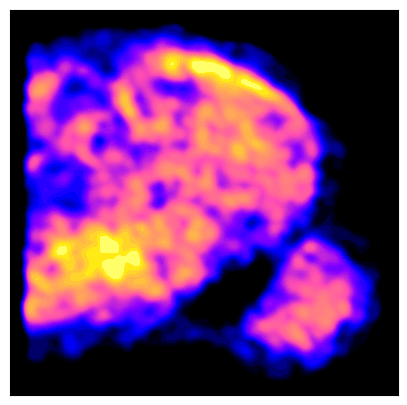

In [83]:
reordered_nmf = cnt_matrix_trans[:, reordered_idx]

sample_idx = np.where(fdata.obs['marker'].values == 'B926-1')[0]

plt.figure(figsize=(5, 5))
sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 89:100].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('black')
plt.xticks([])
plt.yticks([])
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(


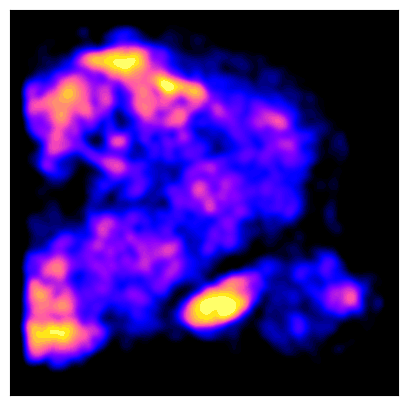

In [84]:
reordered_nmf = cnt_matrix_trans[:, reordered_idx]

sample_idx = np.where(fdata.obs['marker'].values == 'B926-1')[0]

plt.figure(figsize=(5, 5))
sns.kdeplot(x=fdata[sample_idx].obsm['spatial'][:, 0],
            y=fdata[sample_idx].obsm['spatial'][:, 1],
            weights=reordered_nmf[sample_idx, 75:82].mean(axis=1),
            cmap='gnuplot2', fill=True, edgecolor='none', levels=50, bw_adjust=0.2)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('black')
plt.xticks([])
plt.yticks([])
plt.show()